### Re plotting and aesthetic changes to the organoid data

In [1]:
# import packages 

import scanpy.external as sce
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler
from seaborn import despine
from seaborn import axes_style
from matplotlib.pyplot import suptitle
import magic # imputation tool; van Dijk et al 2018 # 
import matplotlib.colors
import scvelo as scv


sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

/home/alm72/.conda/envs/KYorg_env/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


#### Load adata_subset

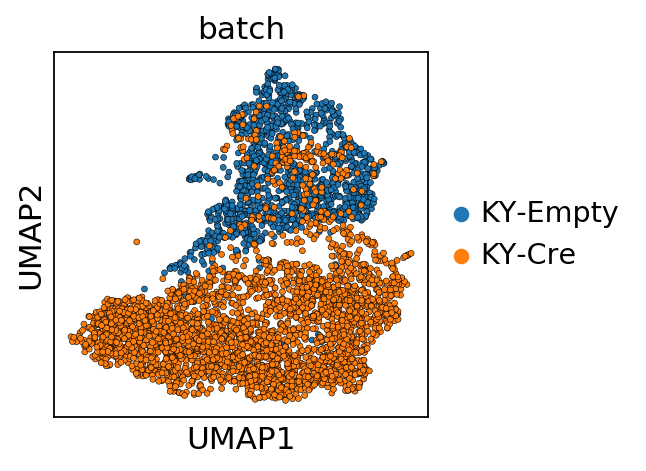

In [2]:
# re-load results

subset_results_file = '/n/data2/bch/hemonc/ckim/AARON/KY_organoid_analysis/write/kras_organoids_subset.h5ad' 
adata_subset = sc.read(subset_results_file)

velocyto_results_file = '/n/data2/bch/hemonc/ckim/AARON/KY_organoid_analysis/write/KYorg_velocyto_merge.h5ad' 
merged = sc.read(velocyto_results_file)

# Work around for loading issue: https://github.com/theislab/anndata/issues/185
adata_subset.raw._varm = None
merged.raw._varm = None

# checks upload visually

rcParams['figure.figsize'] = [3,3]
rcParams["figure.facecolor"]='white'
sc.pl.umap(adata_subset, color = ['batch'], wspace=0.8, legend_loc = 'right margin', edgecolor='black', linewidth=0.25)

#### Re-made stacked barplots -> normalized

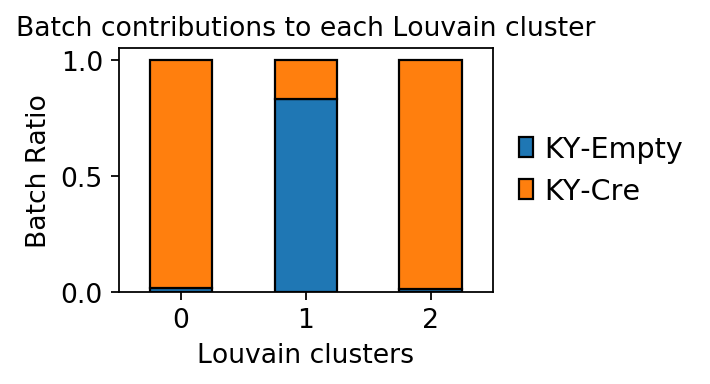

In [9]:
# Stacked bar plot

df=adata_subset.obs
df_plot = df.groupby(['batch', 'louvain_r0.2']).size().reset_index().pivot(columns='batch', index='louvain_r0.2', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

# plot
rcParams['figure.figsize'] = 3,2
with axes_style({'axes.grid': False}):
    df3.plot(kind='bar', stacked=True, edgecolor='Black')
plt.ylabel('Batch Ratio', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.title('Batch contributions to each Louvain cluster',fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False)

In [35]:
print('Number of cells per louvain cluster:')
adata_subset.obs['louvain_r0.2'].value_counts()

Number of cells per louvain cluster:


0    1793
1    1425
2    1017
Name: louvain_r0.2, dtype: int64

#### Transcription factor heatmap

In [39]:
# identify all DE TF's 

# import list of mouse TFs from TFDB
# http://bioinfo.life.hust.edu.cn/AnimalTFDB/#!/species
df_tf = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='TF and TFCs Animal TFDB3', header=0) # load lists 
tf_genes = set(df_tf['Symbol'].tolist())

# Find TF/TFCs in the filtered DE genes list
# Manaully filtered for pval < 0.05 in excel
diff_padj_filtered = pd.read_excel('adata_subset_DE_top1000_filtered.xlsx', header = 0) # previously generated using in built ScanPy function
names = diff_padj_filtered.columns
clust_dict = {} #key,value

for col in diff_padj_filtered.columns:
    
    # get diff gene list
    cluster_genes = diff_padj_filtered[col].tolist()

    # Create results array
    results_tfs = []

    # iterate through and pull out TF/TFCs
    
    for i in tf_genes:
     if i in cluster_genes:
      results_tfs.append(i)
    
    #store in dict (receptors,ligands,tfs)
    the_key = col
    the_value = {}
    the_value["tfs"] = results_tfs
    clust_dict[the_key] = the_value

# Create a list of identified TFs
merged_tf = []

for i in clust_dict:
    sub_dict = clust_dict[i] #access each cluster in dict
    
    # create merge
    merged_tf += sub_dict["tfs"]
    
# Print result
print('Total sig DE TF in organoid clusters:',len(merged_tf))

Total sig DE TF in organoid clusters: 29


In [41]:
# Create dictionary of cluster specific TFS

print('Results')

organoid_DE_data = pd.read_excel("adata_subset_DE_top1000_filtered.xlsx", header = 0) # previously generated using in built ScanPy function
C1_list = list(organoid_DE_data['1_n']) # control
C2_list = list(organoid_DE_data['2_n']) # Id1
C0_list = list(organoid_DE_data['0_n']) # Sox9

# import list of mouse TFs from TFDB
# http://bioinfo.life.hust.edu.cn/AnimalTFDB/#!/species
df_tf = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='TF and TFCs Animal TFDB3', header=0) # load lists 
tf_genes = set(df_tf['Symbol'].tolist())

# make dictionary
organoid_tf_dict = {}

organoid_tf_dict.update({'Cluster 1 organoid TFs':[x for x in C1_list if x in tf_genes]})
organoid_tf_dict.update({'Cluster 2 organoid YFP neg TF':[x for x in C2_list if x in tf_genes]})
organoid_tf_dict.update({'Cluster 0 organoid YFP pos TF':[x for x in C0_list if x in tf_genes]})

for k,v in organoid_tf_dict.items():
    print(f'Number of {k} TF/TFCs:',len(v))

Results
Number of Cluster 1 organoid TFs TF/TFCs: 10
Number of Cluster 2 organoid YFP neg TF TF/TFCs: 5
Number of Cluster 0 organoid YFP pos TF TF/TFCs: 14


In [42]:
# View dictionary
organoid_tf_dict

{'Cluster 1 organoid TFs': ['Cebpa',
  'Etv5',
  'Nfix',
  'Foxp2',
  'Srebf1',
  'Nfic',
  'Stat3',
  'Gtf2i',
  'Irx3',
  'Yeats4'],
 'Cluster 2 organoid YFP neg TF': ['Id1', 'Cenpa', 'Lyar', 'Foxq1', 'Max'],
 'Cluster 0 organoid YFP pos TF': ['Sox9',
  'Elk3',
  'Foxq1',
  'Ets2',
  'Klf7',
  'Trp53',
  'Maff',
  'Plscr1',
  'Smad7',
  'Zmat3',
  'Zfp560',
  'Camta1',
  'Zfp664',
  'Tead1']}

#### Plot

Text(0, 0.5, 'Expression')

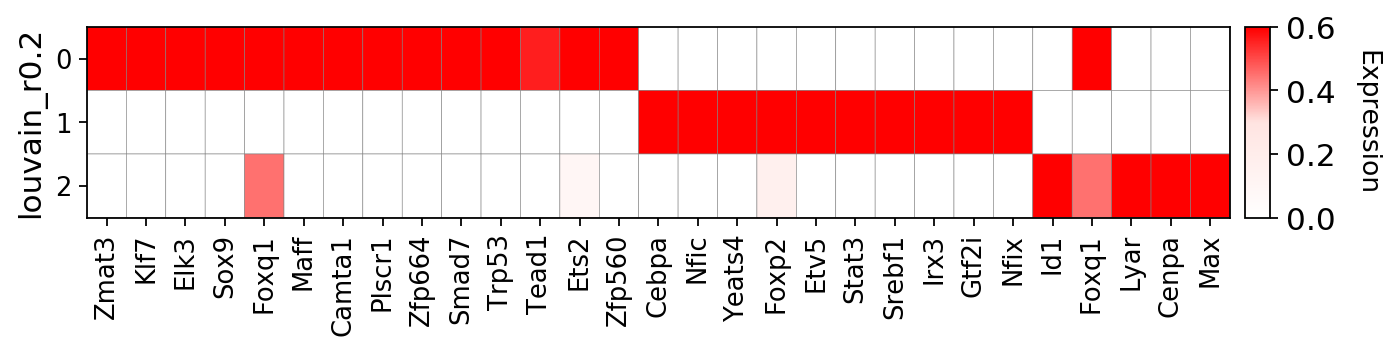

In [40]:
adata_subset_scaled = sc.pp.scale(adata_subset, copy=True)

cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'mistyrose','red'])

rcParams['figure.figsize'] = 2,10
sc.pl.matrixplot(adata_subset_scaled, var_names=merged_tf, cmap=cmap2, groupby='louvain_r0.2', 
use_raw=False, swap_axes=False, vmin=0, vmax=0.6, dendrogram=False, show=False)
plt.ylabel('Expression',fontsize=12, labelpad=20, rotation=270)

### RNA Velocity using pre-computed UMAP embedding
- Import loom files generated by Velocyto
- Merge adata and loom data
- Compute velocity using the original UMAP embedding

In [60]:
# crete anndata using velocyto loom output files
filenames = [
'/n/data2/bch/hemonc/ckim/AARON/KY_organoid_analysis/velocyto_loom_files/DEC13_POOL_ADKYEMP_SI-GA-A8.loom',
'/n/data2/bch/hemonc/ckim/AARON/KY_organoid_analysis/velocyto_loom_files/DEC13_POOL_ADKYCRE_SI-GA-A9.loom'      
]

bdatas = [sc.read_loom(filename) for filename in filenames]
bdata = bdatas[0].concatenate(bdatas[1:], batch_categories=['KY_empty','KY_cre'])
bdata.var_names_make_unique() 

# Make a copy of adata files with computed UMAP for merging with loom anndata files
adata_velo = adata_subset.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Making variable names unique for controlled concatenation.


In [62]:
''''''''''
Merge velocyto data with filtered adata contain computed UMAP

Credit: Merging scvelo with adata
https://github.com/theislab/scvelo/issues/37

'''''''''

merged = scv.utils.merge(adata_velo, bdata)
print('Number of cells before merge:',len(adata_velo.obs.index))
print('Number of cells in bdata:',len(bdata.obs.index))
print('Number of cells after merge:',len(merged.obs.index))

Number of cells before merge: 4235
Number of cells in bdata: 4570
Number of cells after merge: 4235


... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


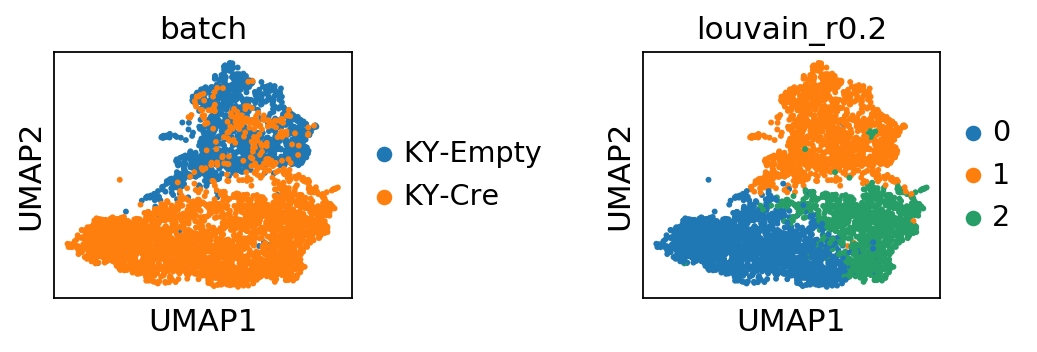

In [63]:
# Plot merged adata/loom data
sc.pl.umap(merged, color=['batch','louvain_r0.2'], ncols=2, wspace=0.8)

In [64]:
# Create velocity graphs
scv.tl.velocity(merged)
scv.tl.velocity_graph(merged)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:27) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


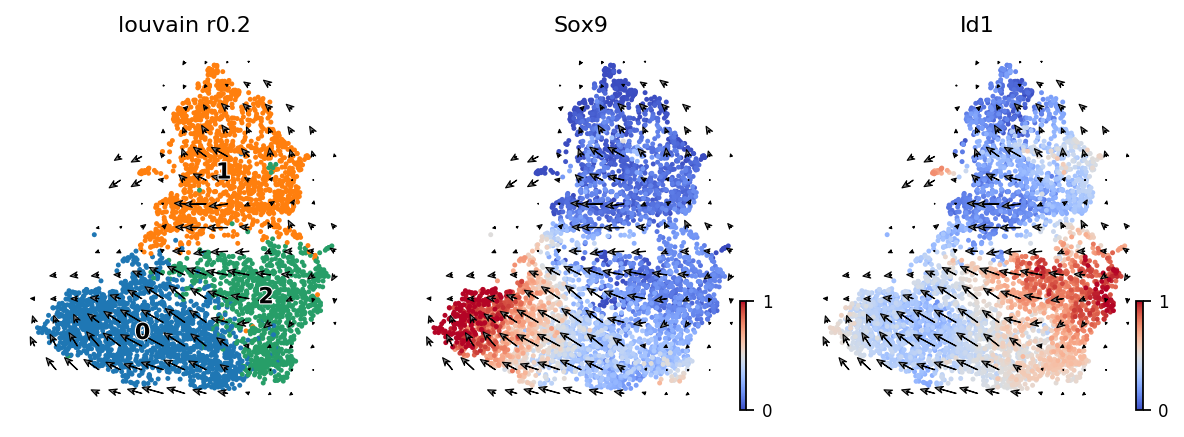

In [27]:
# add genes to merged.obs because use_raw does not work

# Plot velocity data on pre-computed UMAP from adata
cmap='coolwarm'
arrow_color='black'
size=20
vmin=0
vmax=1
figsize=(3,3)
fontsize=10

genes = ['Sox9','Id1']

for gene in genes:
    merged.obs[gene]=merged[:, [gene]].to_df()

with axes_style({'axes.grid': False}):
    ax=scv.pl.velocity_embedding_grid(merged, density=0.3, basis='umap', arrow_length=2, arrow_size=4, 
    alpha=1, color=['louvain_r0.2'] + genes, legend_loc='on data', size=size, ncols = len(genes)+1, 
    figsize=figsize, dpi=(80), frameon=False, color_map=cmap, fontsize=10, vmin=vmin, vmax=vmax,
    legend_fontsize=10, arrow_color=arrow_color, linewidth=0.5)

# remove genes from merged.obs
merged.obs = merged.obs.drop(genes, axis=1)